In [1]:
# Bibliotecas necessárias para o experimento

import numpy as np, numpy.random
import matplotlib.pyplot as plt
from random import randint
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from random import randint, uniform, random
from scipy.linalg import sqrtm

In [2]:
## CONSTANTES PARA O ALGORITMO GENÉTICO

ELITISMO = True
PORCENTAGEM_ELITISMO = 0.20

TAMANHO_POP = 50
TAXA_MUTACAO = 0.10
TAXA_CRUZAMENTO = 0.70
GERACOES = 100

# Valores mínimos e máximos para gerar uma população
MIN = 0
MAX = 400
 # 115, 150

In [3]:
def S(Ut, Uf, X):
    W = np.dot(np.transpose(Uf), Ut)
    T = np.transpose(W)
    A = np.dot(np.transpose(Ut), np.transpose(X))
    C = np.dot(A, Uf)
    L = W - np.identity(3) - 1/2*(W - np.identity(3))**2
    S = 2*np.trace(np.dot((-np.dot(T, C) + 2*C),L))
    #S = 2*np.trace(np.dot((-1/2*np.dot(C, T) - 1/2*np.dot(T, C) + 2*C),L))
    return S

In [4]:
def field(Ut, Uf, a, h, A, B):
    SA = S(Ut, Uf, A)
    SB = S(Ut, Uf, B)
    f = -a*SA-h*(SB/SA)
    return f

In [5]:
def lind(u, Ut, Uf, t, lbda):
    n = 1
    Ax = [[0, 0, 0],[0, 0, -1], [0, 1, 0]]
    Ay = [[0, 0, 1],[0, 0, 0], [-1, 0, 0]]
    Az = [[0, -1, 0],[1, 0, 0], [0, 0, 0]]
    B = [[(1-n*2)*lbda, 0, 0],[0, (1-n*2)*lbda, 0], [0, 0, (-n*2)*lbda]] # Amplitude Damping
    #B = [[-1.01*lbda, 0, 0],[0, -1.01*lbda, 0], [0, 0, -0.01*lbda]] # Phase Damping
    if t == 0:
        fx = u[0]
        fy = u[1]
        fz = u[2]
        F=np.dot(u[0],Ax)+np.dot(u[1],Ay)+np.dot(u[2],Az)+B
    else:
        fx=field(Ut, Uf, u[0], 0.35, Ax, B)
        fy=field(Ut, Uf, u[1], 0.31, Ay, B)
        fz=field(Ut, Uf, u[2], 0.34, Az, B)
        P=400

        if abs(fx) > P:
            if fx < 0:
                fx = -P
            else:
                fx = P
        if abs(fy) > P:
            if fy < 0:
                fy = -P
            else:
                fy = P
        if abs(fz) > P:
            if fz < 0:
                fz = -P
            else:
                fz = P

        F=np.dot(fx,Ax)+np.dot(fy,Ay)+np.dot(fz,Az)+B
        	
    return fx,fy,fz,F

In [6]:
def rungeKutta(u, Ut, Uf, h, t, lbda):

    if t == 0:
        
        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    else:

        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t+h/2, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t+h/2, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t+h, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    
    result = Ut+(h/6)*(k1+2*k2+2*k3+k4);
    return a,b,c,result

In [7]:
def func_objetivo(u, Ut, Uf, h, tempo, lbda):
    a, b, c, Ut1 = rungeKutta(u, Ut, Uf, h, tempo, lbda)
    return (np.linalg.norm(Ut1-Uf))**2

In [8]:
def gerar_populacao():
    populacao = np.zeros((TAMANHO_POP,3))
    for individuo in range(TAMANHO_POP):
        for genes in range(3):
            populacao[individuo,genes] = uniform(MIN, MAX)
    return populacao

In [9]:
def calcular_func(populacao, Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    valor_func = np.zeros(TAMANHO_POP)
    for individuo in range(TAMANHO_POP):
        valor_func[individuo] = func_objetivo(populacao[individuo,:], Ut, Uf, h, tempo, lbda)
    return valor_func

In [10]:
def selecao(valor_fitness):
    pos = np.random.choice(range(TAMANHO_POP), 2, replace=False)
    valor = valor_fitness[pos[0]] < valor_fitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [11]:
def divisao_fitness(valor_funcao_objetivo):
    divisao = 0
    for i in range(len(valor_funcao_objetivo)):
        divisao += valor_funcao_objetivo[i]
    return divisao

def fitness(valor_funca_objetivo):
    return valor_funca_objetivo/divisao_fitness(valor_funca_objetivo)

In [12]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [13]:
def mutacao(individuo, horizonte):
    
    # Gaussian function
    for i in range (0, horizonte):
        if random() < TAXA_MUTACAO:
            individuo[i] = (1/np.sqrt(2*np.pi))*np.exp((-1/2*(uniform(MIN, MAX)-2)**2))
    
    return individuo

In [14]:
def genetico(Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    
    horizonte = 3
    pop = gerar_populacao()
    fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
    fit = fitness(fo)
    fit_edit = fit
    min_fit = min(fit)
            
    melhor_fo = np.zeros(GERACOES)
    for geracao in range(GERACOES):
        new_pop = np.empty((0, horizonte))
        for i in range(round((TAMANHO_POP)/2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < TAXA_CRUZAMENTO:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :])
                filho1 = mutacao(filho1, horizonte)
                filho2 = mutacao(filho2, horizonte)
                new_pop = np.vstack([new_pop, filho1, filho2])
            else:
                pais = np.vstack([mutacao(pop[pai1, :], horizonte), mutacao(pop[pai2, :], horizonte)])
                new_pop = np.vstack([new_pop, pais])
                
        fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
        fit = fitness(fo)
        min_fo = min(fo)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)
                
    return pop[pos_min_fo,:][0,0]

In [15]:
def leis_controle(fx, fy, fz, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    plt.ylabel("Valores das leis de controle") 
    plt.xlabel('Tempo (u. a.)') 
    plt.plot(ts, fx, color='g', marker='o', linewidth=1, markersize=1, label="$f_x(t)$")
    plt.plot(ts, fy, color='b', marker='_', linewidth=1, markersize=1, label="$f_y(t)$")
    plt.plot(ts, fz, color='r', marker='.', linewidth=1, markersize=1, label="$f_z(t)$")
    plt.legend(loc="upper right")
    plt.title(fr"Leis de controle para $\gamma = {lbda}$")
    plt.show()

In [16]:
def fidelidade(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de fidelidade") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Fidelidade com $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [17]:
def distance(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de distância") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Distância entre os operadores de evolução com $\gamma = {lbda}$")

    #x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    #axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    #axins.set_xlim(0.009, 0.020)
    #axins.set_ylim(0.98, 1)

    #axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    #ax.indicate_inset_zoom(axins)
    
    plt.show()

In [18]:
def densidade(rho, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel('Valores da matriz de densidade') 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    ax.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    ax.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    ax.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Evolução da matriz de densidade $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(max(abs(rho[0])), max(abs(rho[1])), max(abs(rho[2])), max(abs(rho[3])))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    axins.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    axins.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    axins.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")

    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [19]:
def main():
    aas = []
    u = [70, 106, 66, 0.35, 0.31, 0.34] # Hadamard
    
    Ut = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    Uf = [[0, 0, 1], [0, -1, 0], [1, 0, 0]] # Hadamard
    
    r0 = [[1], [0], [0]]
    rf = np.dot(Uf, r0)
    pf = [[1/2*(1+rf[2][0]), 1/2*(rf[0][0]-1j*rf[1][0])], [1/2*(rf[0][0]+1j*rf[1][0]), 1/2*(1-rf[2][0])]]
    
    h=0.001
    t=0
    i=0
    lbda=0.01
    # Proposta do algoritmo genético
    resultado_algoritmo_genetico = genetico(Ut, Uf, h, t, TAMANHO_POP, lbda) 
    u[0] = resultado_algoritmo_genetico[0]
    u[1] = resultado_algoritmo_genetico[1]
    u[2] = resultado_algoritmo_genetico[2]
    aas.append((u[0],u[1],u[2]))
    distance_vector = []
    fx_vector = []
    fy_vector = []
    fz_vector = []
    rho_vector = np.zeros((4,100),dtype=np.complex128)
    fid_vector = []
    fid_autores = []
       
    while t < 100:
        a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
        D = np.linalg.norm(Uto-Uf)**2
        #print(f"Uf: {Uf}")
        #print(f"Uto: {Uto}")
        #print(f"Valores de u: {u}")
        distance_vector.append(D)
        fx_vector.append(a)
        fy_vector.append(b)
        fz_vector.append(c)
        rt = np.dot(Uto, r0)
        pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
        rho_vector[0][t] = pt[0][0]
        rho_vector[1][t] = pt[0][1]
        rho_vector[2][t] = pt[1][0]
        rho_vector[3][t] = pt[1][1]
        fid_vector.append((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
        fid_autores.append((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
        resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
        u[0] = resultado_algoritmo_genetico[0]
        u[1] = resultado_algoritmo_genetico[1]
        u[2] = resultado_algoritmo_genetico[2]
        aas.append((u[0],u[1],u[2]))
        #print(f"Tempo: {t}")
        Ut = Uto
        t += 1

    print(f"O rho gerado foi: {pt}")
    rt = np.dot(Ut, r0)
    pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
    
    #leis_controle(fx_vector,fy_vector,fz_vector,t,lbda)
    #densidade(rho_vector,t,lbda)
    #fidelidade(fid_vector,t,lbda)
    #fidelidade(fid_autores,t,lbda)
    #distance(distance_vector,t,lbda)

    return fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, aas

In [20]:
import matplotlib.pyplot as plt

def histograma(componente, valores_as):

    valores = []
    # Extração dos valores para o componente escolhido
    valores_intermediarios = [sublista for sublista in a]
    for i in valores_intermediarios:
        valores.append(i[componente])
    
    # Criação do histograma
    plt.hist(valores, bins=10, edgecolor='black')
    plt.xlabel(f'Componente {["x", "y", "z"][componente]}')
    plt.ylabel('Frequência')
    plt.title(f'Histograma do Componente {["x", "y", "z"][componente]}')
    plt.show()


Tempo: 1
Começará a função principal
O rho gerado foi: [[np.float64(1.0009203798850028), np.complex128(-0.00047067600706794395+1.573491768738294e-05j)], [np.complex128(-0.00047067600706794395-1.573491768738294e-05j), np.float64(-0.000920379885002709)]]
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.5003246355601886264-7.368529155440654447e-09j'), np.clongdouble('0.5033838138827378089-1.8810976661445288421e-06j'), np.clongdouble('0.5033609914392896308-2.6676315557620863896e-05j'), np.clongdouble('0.50372610100152070793-0.00014636913446384765009j'), np.clongdouble('0.5037554787605662724+0.00020506822579218600657j'), np.clongdouble('0.5038578716462142743-8.497212928445095053e-05j'), np.clongdouble('0.6471102303190090224+0.00010578037861170637041j'), np.clongdouble('0.6470910113339273745-6.675840587619602207e-05j'), np.clongdouble('0.6470098545811596803+0.00016355048851394700303j'), np.clongdouble('0.6471203445039285336+0.00011891793533125529418j'), np.clongdouble

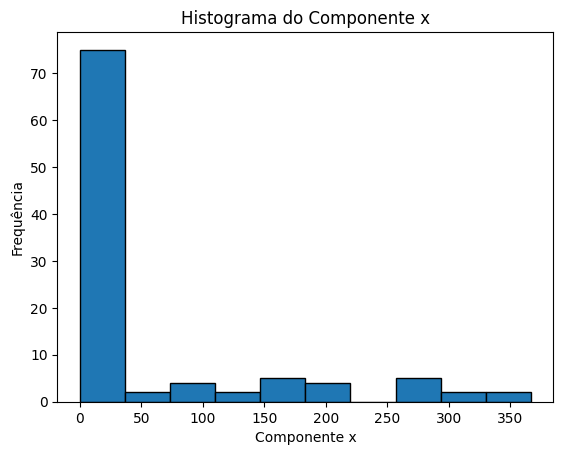

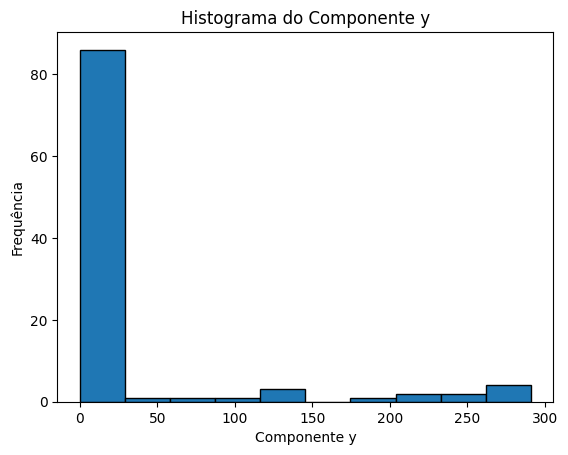

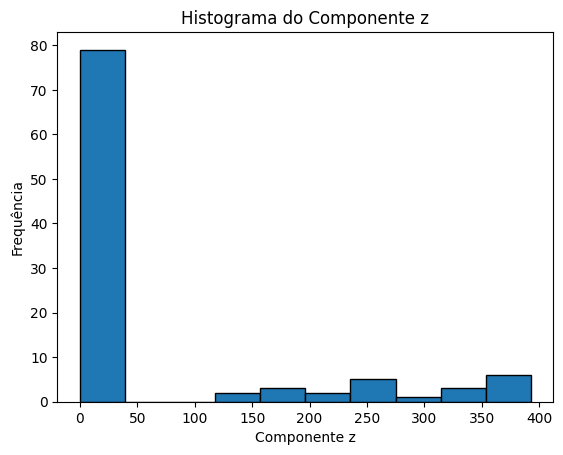

Terminou o histograma
Valores de média na iteração 1:
Portas: 1.005040925268829
Estados: (1.00092016044568-4.751068601444984e-07j)
Distância: 2.2181440804617044e-05
 
Tempo: 2
Começará a função principal
O rho gerado foi: [[np.float64(1.0078754396406124), np.complex128(0.00151856859684541-0.0002673852593312639j)], [np.complex128(0.00151856859684541+0.0002673852593312639j), np.float64(-0.007875439640612436)]]
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.4632704850164991129-0.00013727065855996996076j'), np.clongdouble('0.46415771468401746682+0.00014218333202201714798j'), np.clongdouble('0.47053054688004864153+4.112724466707185159e-06j'), np.clongdouble('0.47031310096220902098+0.00019907993760866281915j'), np.clongdouble('0.55612755770799728944+0.00034594467879139991144j'), np.clongdouble('0.556123002218666676-0.0002129171891990635578j'), np.clongdouble('0.5966551990638960539-6.5808394008485395835e-05j'), np.clongdouble('0.73223663764778158445+7.715194513004742

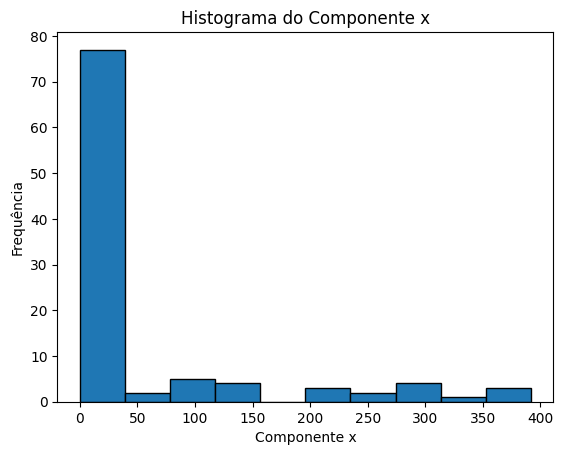

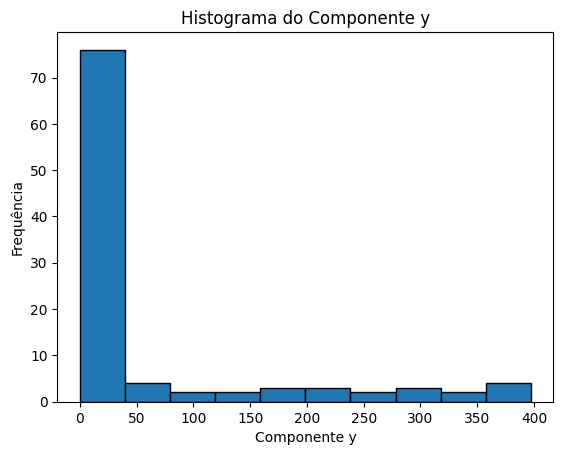

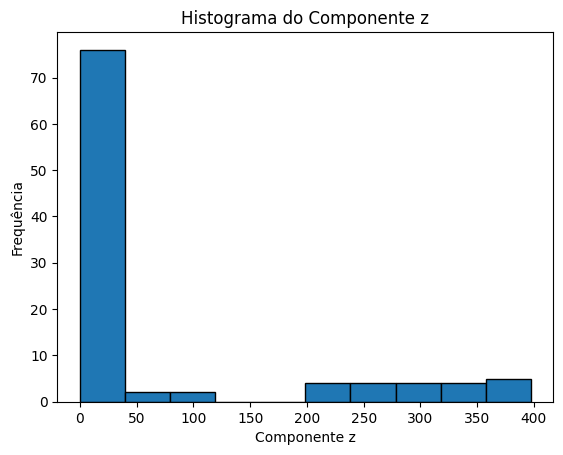

Terminou o histograma
Valores de média na iteração 2:
Portas: 1.0160732295031507
Estados: (1.004398556091198-5.396531028331585e-07j)
Distância: 0.0003484734561919098
 
Tempo: 3
Começará a função principal
O rho gerado foi: [[np.float64(1.041503859477845), np.complex128(0.00010866249399236978+0.005482628590845978j)], [np.complex128(0.00010866249399236978-0.005482628590845978j), np.float64(-0.04150385947784485)]]
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.50014465186685759925+0j'), np.clongdouble('0.5002439058932154656-0.00012208080669796815175j'), np.clongdouble('0.5058631144022387417+0.00014626161375137334046j'), np.clongdouble('0.5062730598817474842+7.349952765661501362e-05j'), np.clongdouble('0.5066465547787131516-0.00033666296984975932362j'), np.clongdouble('0.5072524117339818296+1.585326694401235445e-05j'), np.clongdouble('0.50538674593693633333+4.7584718367512249894e-06j'), np.clongdouble('0.5051481546666589299-0.000206517672851222942j'), np.clongdoub

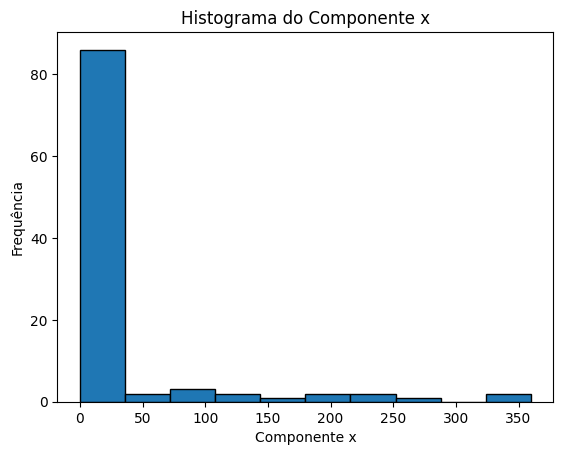

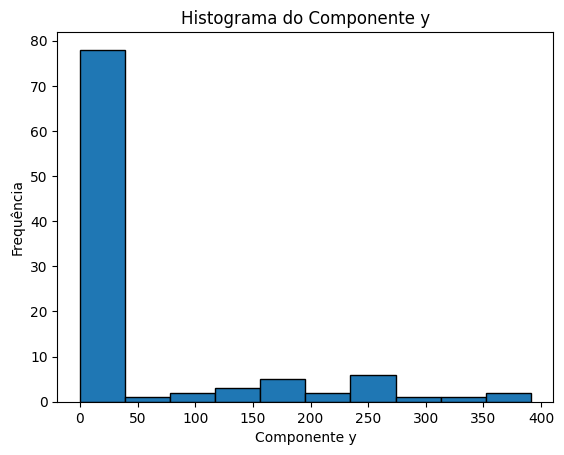

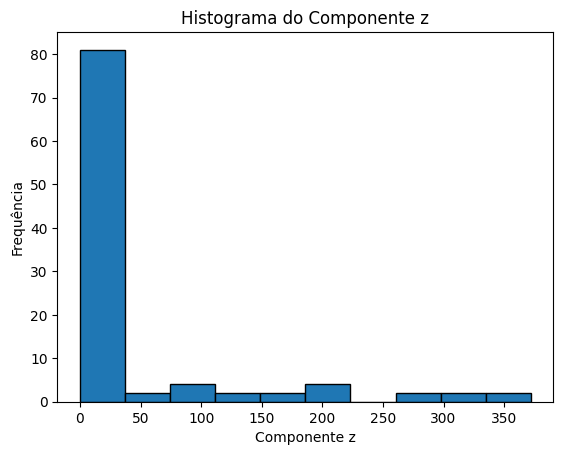

Terminou o histograma
Valores de média na iteração 3:
Portas: 1.048103277466777
Estados: (1.0167675390778204-6.116662304301978e-07j)
Distância: 0.004773192224257233
 
Tempo: 4
Começará a função principal
O rho gerado foi: [[np.float64(0.9998044213202752), np.complex128(-0.0006963729027577683-0.000201727302263136j)], [np.complex128(-0.0006963729027577683+0.000201727302263136j), np.float64(0.000195578679724695)]]
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.50014571247587111995-6.402100374953992303e-06j'), np.clongdouble('0.50016659604733964964+0.00025328052938456177426j'), np.clongdouble('0.5001435025313528949-0.00029038966080405628928j'), np.clongdouble('0.4616434832266905021-1.4666039206123565534e-11j'), np.clongdouble('0.46158007351450338-0.00020347877606502041172j'), np.clongdouble('0.46173119243647237306-4.500852804660452362e-05j'), np.clongdouble('0.6568732120304659307-0.00028191468890094736124j'), np.clongdouble('0.67133928472768723567-0.00022950472083

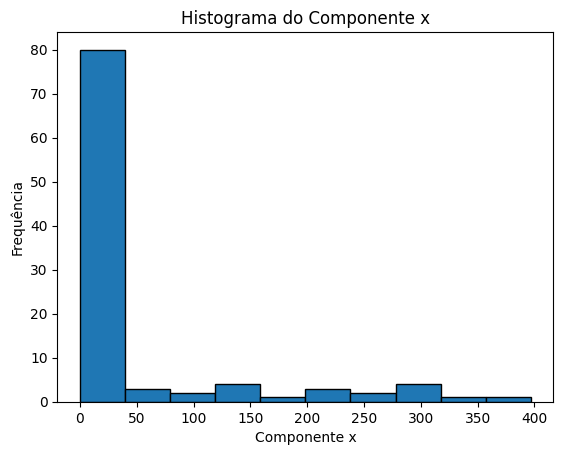

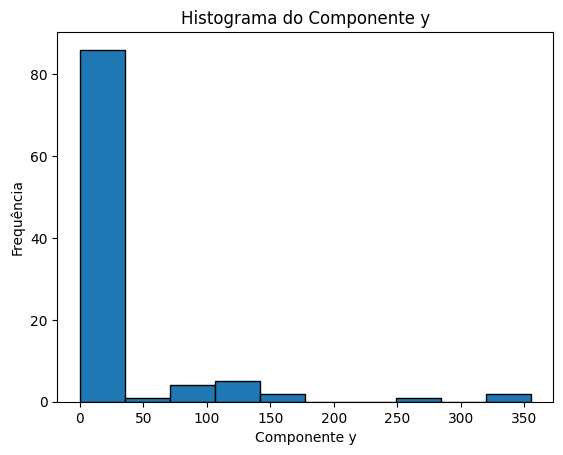

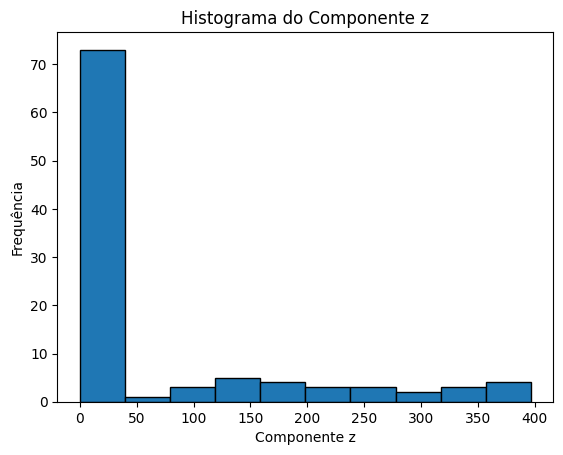

Terminou o histograma
Valores de média na iteração 4:
Portas: 1.036488438952603
Estados: (1.0125267878028725-4.805534154587211e-07j)
Distância: 0.003581661825295997
 
Tempo: 5
Começará a função principal


/tmp/ipykernel_2230/116918231.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  f = -a*SA-h*(SB/SA)


O rho gerado foi: [[np.float64(1.0019926052712882), np.complex128(0.00011667649777958664-0.0002513680575995311j)], [np.complex128(0.00011667649777958664+0.0002513680575995311j), np.float64(-0.0019926052712881948)]]
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.40113545473809037695+0.00010922419855463396625j'), np.clongdouble('0.42153422541463544224+4.295361899646005466e-09j'), np.clongdouble('0.42174923160864724565+0.00020564397547543737394j'), np.clongdouble('0.48764091817541878413+0.00018145487624172041235j'), np.clongdouble('0.48815348756206500773+0.000151979725601030598j'), np.clongdouble('0.48837275026331063355-7.4959002869404842076e-06j'), np.clongdouble('0.4882773900673543202-0.00015184243910436050839j'), np.clongdouble('0.4882192338662417468+8.393852372624495091e-05j'), np.clongdouble('0.48839289177259767426-9.49805354047073405e-05j'), np.clongdouble('0.6674397440707434441-3.8784526354391960253e-05j'), np.clongdouble('0.6672319410242624885-0.000269691

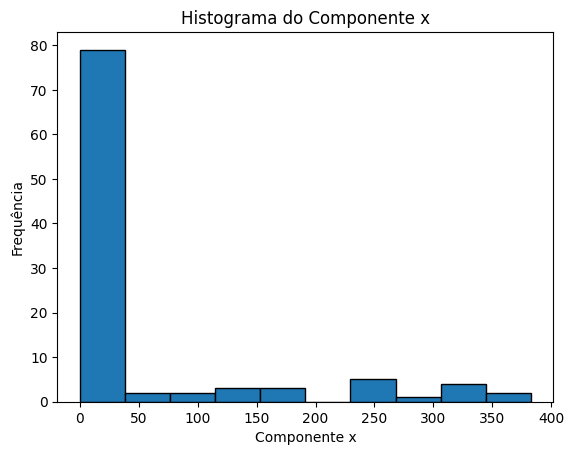

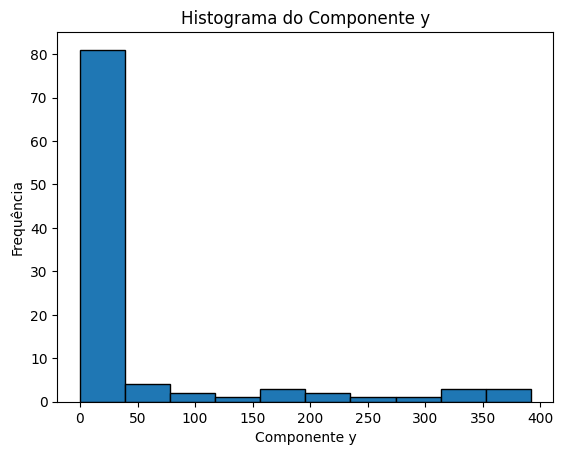

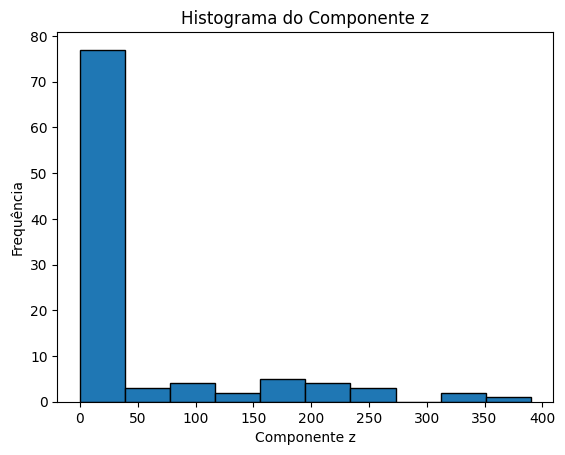

Terminou o histograma
Valores de média na iteração 5:
Portas: 1.0302360818930512
Estados: (1.01042002414808-3.9101385763451214e-07j)
Distância: 0.002873371086331655
 
Tempo: 6
Começará a função principal
O rho gerado foi: [[np.float64(1.0040225934033113), np.complex128(-0.0011372325376392625+0.0014687536065806344j)], [np.complex128(-0.0011372325376392625-0.0014687536065806344j), np.float64(-0.0040225934033113475)]]
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.40639183152116194734+0.000111204114331705312j'), np.clongdouble('0.40636745908627212-0.00023755256051991170478j'), np.clongdouble('0.42618475599218564497+8.113117357988992233e-06j'), np.clongdouble('0.45755961613368208662-2.3518597759026596845e-05j'), np.clongdouble('0.457557047749289119-4.526011526013607453e-05j'), np.clongdouble('0.46119321949536398484+0.00014748492863948692257j'), np.clongdouble('0.4611757931728814246+0.00027193456788116031392j'), np.clongdouble('0.46198556701584095555-0.000161316823

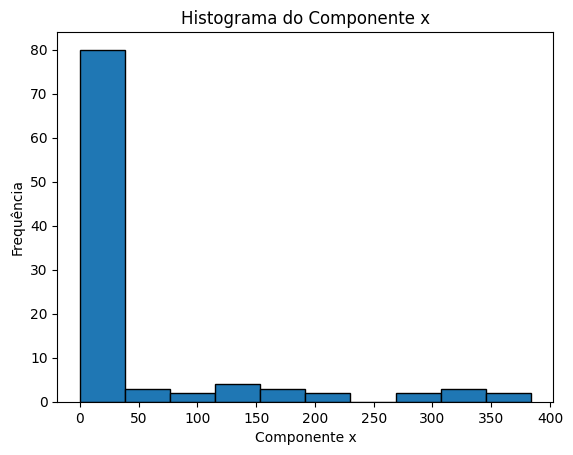

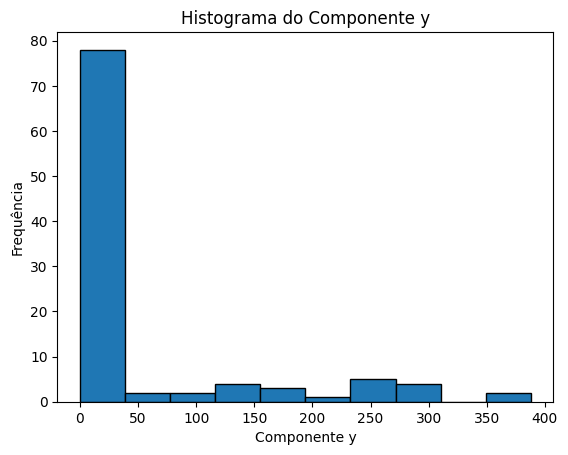

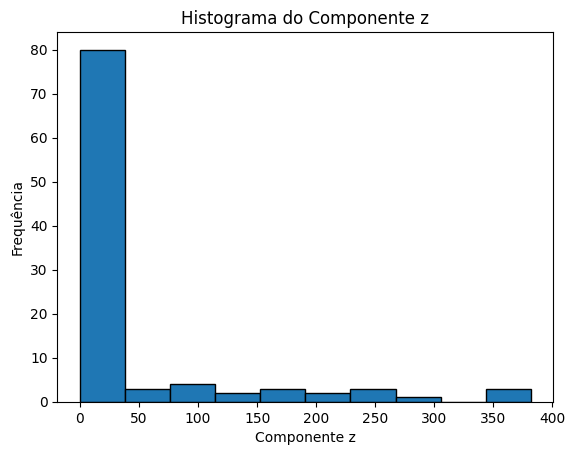

Terminou o histograma
Valores de média na iteração 6:
Portas: 1.0284360717691112
Estados: (1.0093539284572055-1.8791715821862483e-07j)
Distância: 0.002450544116493305
 
Tempo: 7
Começará a função principal
O rho gerado foi: [[np.float64(1.0077142875575738), np.complex128(-7.479032103193723e-05+0.0022328322587021636j)], [np.complex128(-7.479032103193723e-05-0.0022328322587021636j), np.float64(-0.007714287557573862)]]
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.5001446599723549793-1.1621773559226677706e-17j'), np.clongdouble('0.41657211501349740128-0.00012096827929406351297j'), np.clongdouble('0.41655741340936877108-0.00014318562733184253447j'), np.clongdouble('0.41659911114108873927-8.186755502490460307e-05j'), np.clongdouble('0.41692932176081488077-3.617625100808166616e-05j'), np.clongdouble('0.41668795213235936684-1.6591122098281106021e-08j'), np.clongdouble('0.41665711550859070805-2.1590766691663372547e-05j'), np.clongdouble('0.4165573701862103989+0.00012

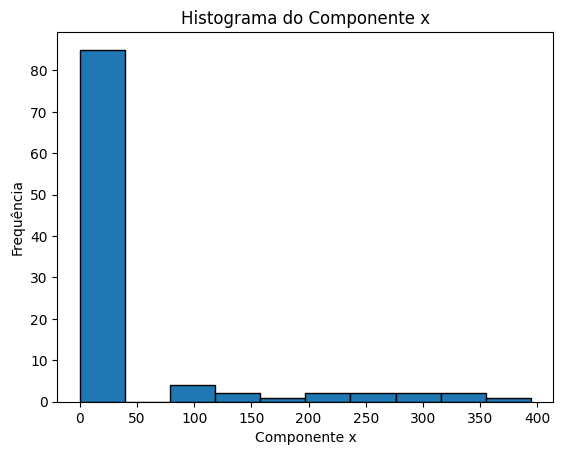

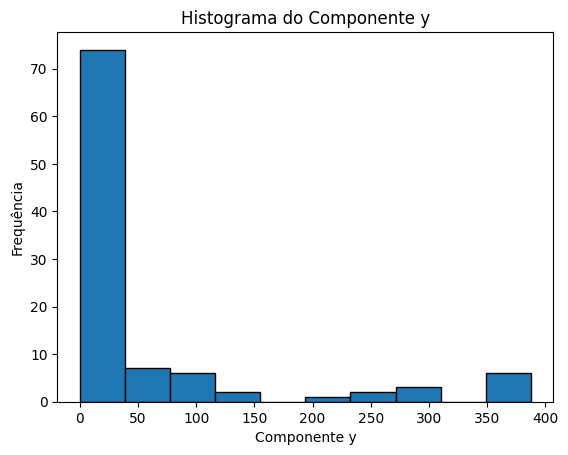

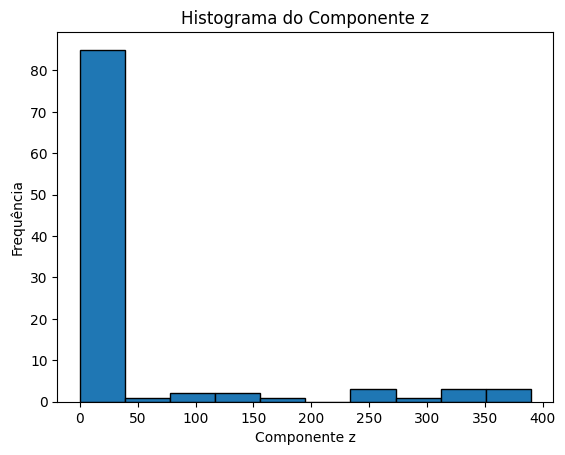

Terminou o histograma
Valores de média na iteração 7:
Portas: 1.027673025609706
Estados: (1.009119928334613-3.192280133136409e-07j)
Distância: 0.002177966680425152
 
Tempo: 8
Começará a função principal
O rho gerado foi: [[np.float64(0.9995992438950854), np.complex128(4.14422293345681e-06-0.0004612911376803188j)], [np.complex128(4.14422293345681e-06+0.0004612911376803188j), np.float64(0.00040075610491463465)]]
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.50014465186685759925+0j'), np.clongdouble('0.5000487852923374221+3.7435747485996392277e-23j'), np.clongdouble('0.5000026397242850266+2.4665010674491512198e-05j'), np.clongdouble('0.60905896544582156235-0.00017996237206576871854j'), np.clongdouble('0.60908106580174462973-0.00022588878329624553657j'), np.clongdouble('0.6091506078835541156+0.0001415263389865385526j'), np.clongdouble('0.6091280321445822469+9.642138646470392157e-05j'), np.clongdouble('0.60999885223971987957-0.00010172483253680437543j'), np.clongd

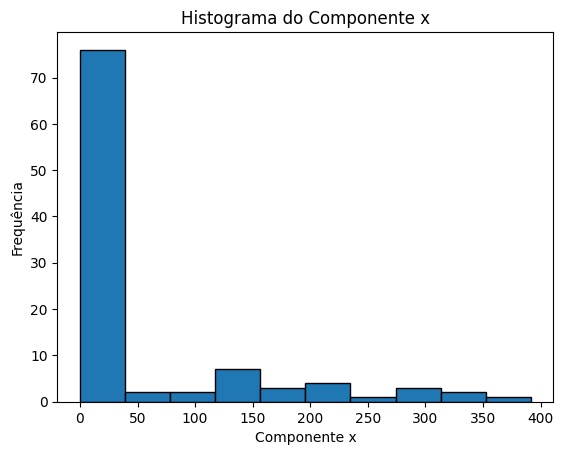

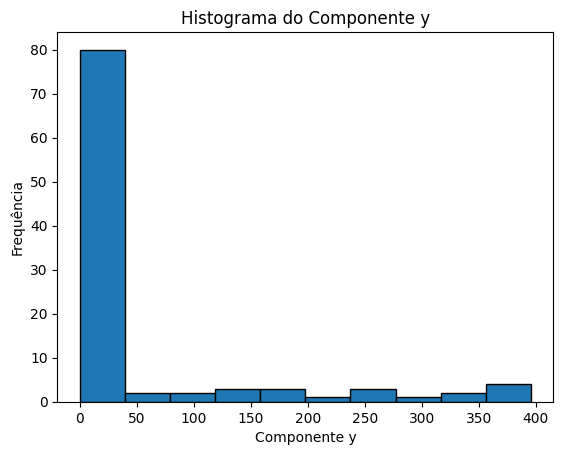

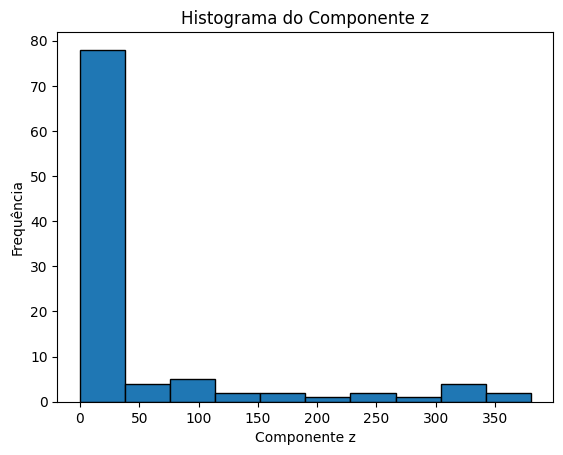

Terminou o histograma
Valores de média na iteração 8:
Portas: 1.0240536380203904
Estados: (1.0079298895866722-2.793245116494358e-07j)
Distância: 0.0019062473039452414
 
Tempo: 9
Começará a função principal
O rho gerado foi: [[np.float64(1.0041654796069406), np.complex128(0.00044494990701554105+0.0020811737397011276j)], [np.complex128(0.00044494990701554105-0.0020811737397011276j), np.float64(-0.004165479606940581)]]
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.50014465186685759925+0j'), np.clongdouble('0.46790163061315129503-0.00016178527475138629443j'), np.clongdouble('0.46784053619689416217+0.00021235730380008987653j'), np.clongdouble('0.4680073757302861869+1.8691070807335075602e-05j'), np.clongdouble('0.46789646632871055096-5.5947796254150985826e-09j'), np.clongdouble('0.4890015303319113907+6.9148967851677726404e-05j'), np.clongdouble('0.48924257308562740183-5.92248776670591274e-06j'), np.clongdouble('0.48891576196401520142+0.00010974030482660709373j'), n

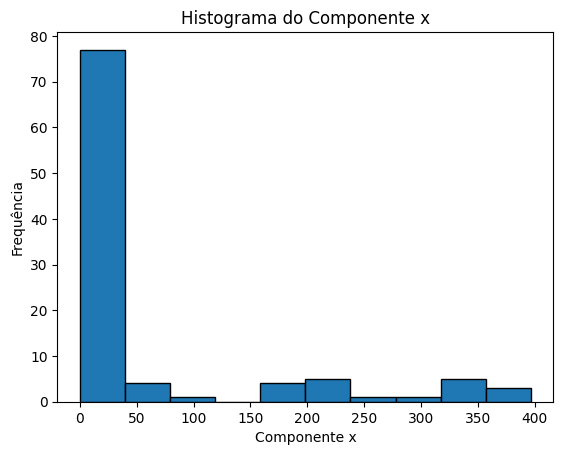

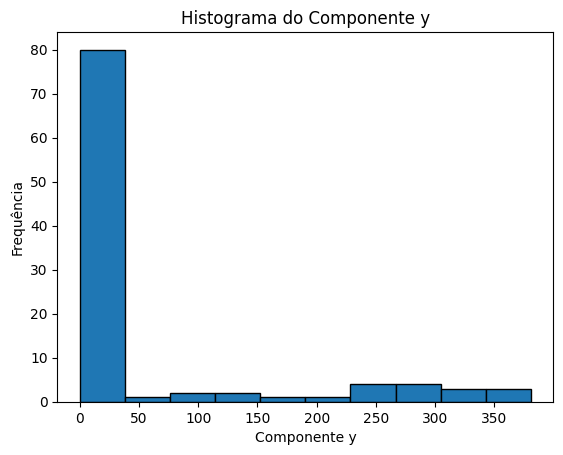

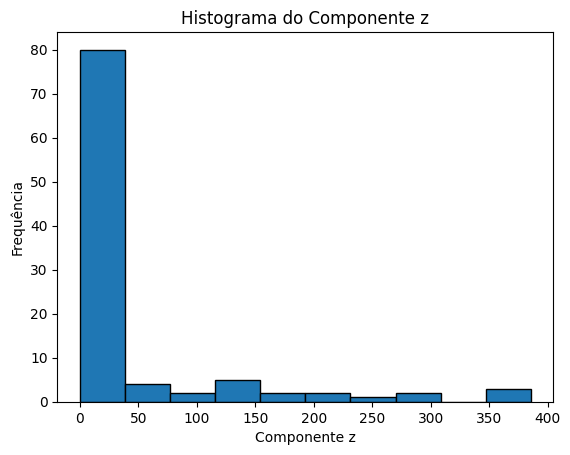

Terminou o histograma
Valores de média na iteração 9:
Portas: 1.022829715785052
Estados: (1.0075115950665448-4.0931669359725144e-07j)
Distância: 0.0017148065764259106
 
Tempo: 10
Começará a função principal
O rho gerado foi: [[np.float64(1.0001670056839793), np.complex128(0.0005445662490075263-0.0012980578675236424j)], [np.complex128(0.0005445662490075263+0.0012980578675236424j), np.float64(-0.0001670056839794265)]]
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.50003762173756849825-2.9010498891418174526e-05j'), np.clongdouble('0.50059486838889027146+1.9870634976762329063e-06j'), np.clongdouble('0.50050839277647261047+0.0001549765463378394613j'), np.clongdouble('0.64610338228529815837+0.00021557841813203733525j'), np.clongdouble('0.7688061338378027382+0.0002298257913043284121j'), np.clongdouble('0.7687654693716412784+9.4111144545313523983e-05j'), np.clongdouble('0.84908708186195497704-0.00011631069503598027869j'), np.clongdouble('0.87439311780062248914+4.95725

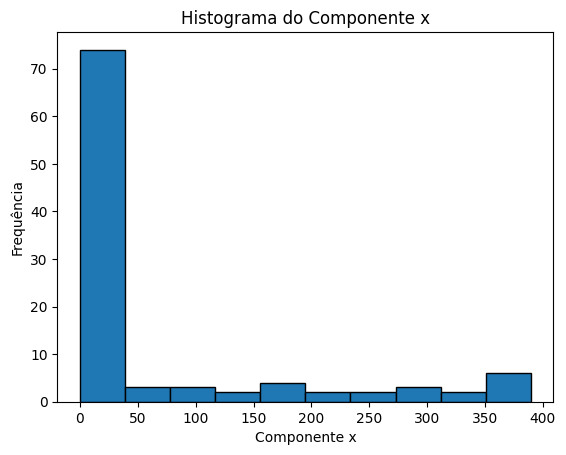

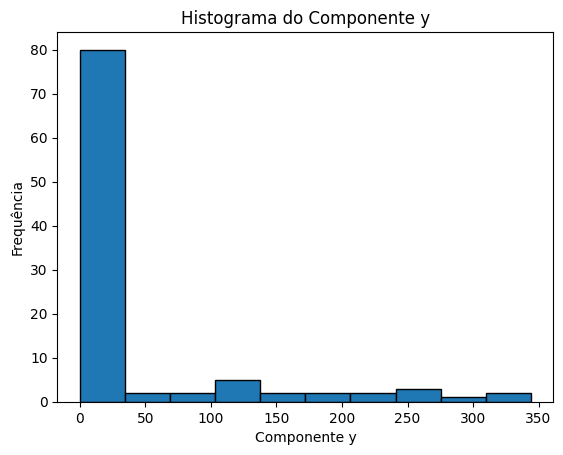

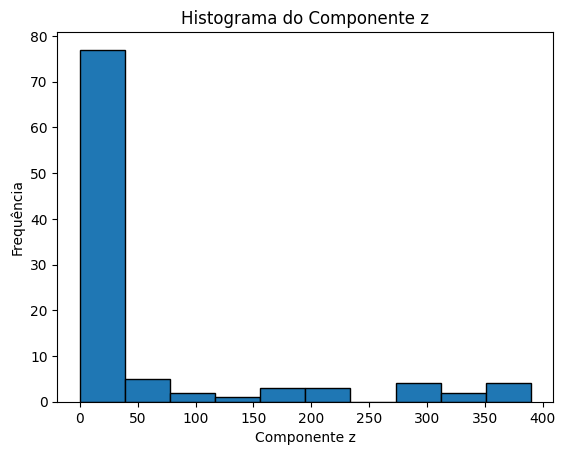

Terminou o histograma
Valores de média na iteração 10:
Portas: 1.0213224267971355
Estados: (1.0067771501134606-4.500239507112023e-07j)
Distância: 0.0015510016274117027
 


In [21]:
portas = []
estados = []
distancia = []

for i in range(1, 11):

    print(f"Tempo: {i}")

    print(f"Começará a função principal")
    fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, a = main()
    print(f"Terminou a função principal")
    print(f"Veja o log: (Dos estados)")
    print(fid_vector)
    print(f"Veja o log: (Das portas)")
    print(fid_autores)

    portas.append(fid_autores[-1])
    estados.append(fid_vector[-1])
    distancia.append(distance_vector[-1])

    print(f"Começou o histograma")
    histograma(0, a)
    histograma(1, a)
    histograma(2, a)
    print(f"Terminou o histograma")
    
    print(f"Valores de média na iteração {i}:")
    print(f"Portas: {sum(portas)/i}")
    print(f"Estados: {sum(estados)/i}")
    print(f"Distância: {sum(distancia)/i}")
    print(" ")